<a href="https://colab.research.google.com/github/Ygorca125/Series-Temporais-aluguel-de-carros/blob/main/Projeto_Aluguel_de_carros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Perguntas a ser respondidas no projeto

1 - Faça previsão da quantidade de diarias por mês para os próximos 12 meses, com um MAE de pelo menos 900 utlizando os últimos 9 meses para teste;

2 - Consiga acuracidade de pelo menos 65% da previsão se vai subir ou descer dentro do modelo

# Análise exploratória

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
df = pd.read_excel('/content/Desafio Aluguel Carros.xlsx')

In [2]:
df.head()

,CONTRATO,DATA DA CRIACAO,DIARIAS,VALOR TOTAL,ORIGEM
0,Loja 11000,2022-12-19,7,1933.88,SITE
1,Loja 21001,2022-07-28,4,748.15,APLICATIVO
2,Loja 11002,2023-08-20,6,459.04,PARCEIRO 1
3,Loja 11003,2022-03-24,10,1079.76,PARCEIRO 2
4,Loja 31004,2022-05-13,1,202.03,SITE


In [3]:
df.describe()

,DATA DA CRIACAO,DIARIAS,VALOR TOTAL
count,54536,54536.000000,54536.000000
mean,2023-08-03 19:27:41.375971328,6.304111,982.185744
min,2022-01-01 00:00:00,1.000000,31.950000
25%,2022-11-29 00:00:00,3.000000,392.215000
50%,2023-08-24 00:00:00,5.000000,722.705000
75%,2024-04-22 00:00:00,8.000000,1261.350000
max,2024-11-28 00:00:00,110.000000,77699.630000
std,NaN,5.812118,965.460037


In [4]:
#Utilizando _ invés de espaço para facilitar as manipulações

df.columns = (
    df.columns
      .str.strip()
      .str.upper()
      .str.replace(' ', '_')
)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54536 entries, 0 to 54535
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   CONTRATO         54536 non-null  object        
 1   DATA_DA_CRIACAO  54536 non-null  datetime64[ns]
 2   DIARIAS          54536 non-null  int64         
 3   VALOR_TOTAL      54536 non-null  float64       
 4   ORIGEM           54536 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 2.1+ MB


In [6]:
#Vamos agrupar a quantidade dos valores das diarias por dia, para saber quantas diarias houveram por mês

# Garantir datetime
df['DATA_DA_CRIACAO'] = pd.to_datetime(df['DATA_DA_CRIACAO'])

# Criar coluna Ano-Mês
df['ANO_MES'] = df['DATA_DA_CRIACAO'].dt.to_period('M')

# Tabela agregada por Ano-Mês
tabela_mensal = (
    df
    .groupby('ANO_MES')
    .agg(
        TOTAL_DIARIAS=('DIARIAS', 'sum'),

    )
    .reset_index()
)

# Converter para datetime para ordenar corretamente
tabela_mensal['ANO_MES'] = tabela_mensal['ANO_MES'].dt.to_timestamp()

# Ordenar
tabela_mensal = tabela_mensal.sort_values('ANO_MES')

tabela_mensal.head()


,ANO_MES,TOTAL_DIARIAS
0,2022-01-01,7579
1,2022-02-01,8059
2,2022-03-01,8155
3,2022-04-01,8733
4,2022-05-01,8078


In [7]:
tabela_mensal.describe()

,ANO_MES,TOTAL_DIARIAS
count,35,35.000000
mean,2023-06-01 13:01:42.857142784,9822.885714
min,2022-01-01 00:00:00,7579.000000
25%,2022-09-16 00:00:00,8701.500000
50%,2023-06-01 00:00:00,9674.000000
75%,2024-02-15 12:00:00,10741.000000
max,2024-11-01 00:00:00,13000.000000
std,NaN,1414.697240


In [8]:
tabela_mensal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ANO_MES        35 non-null     datetime64[ns]
 1   TOTAL_DIARIAS  35 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 692.0 bytes


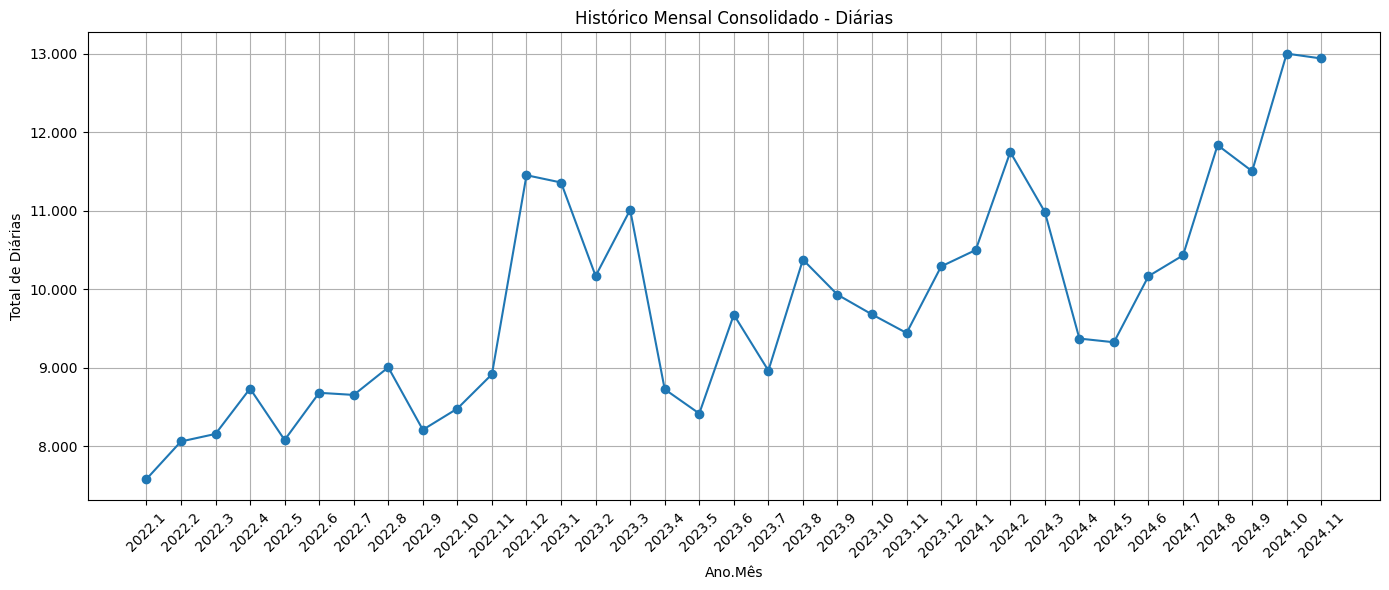

In [9]:
import matplotlib.ticker as ticker

# Agrupar somando todas as origens
df_mensal_diarias = (
    df
    .groupby('ANO_MES')['DIARIAS']
    .sum()
    .reset_index()
)

# Converter para datetime para ordenar corretamente
df_mensal_diarias['ANO_MES'] = df_mensal_diarias['ANO_MES'].dt.to_timestamp()

# Ordenar
df_mensal_diarias = df_mensal_diarias.sort_values('ANO_MES')

# Criar label no formato 2022.1
df_mensal_diarias['ANO_MES_LABEL'] = (
    df_mensal_diarias['ANO_MES'].dt.year.astype(str) +
    '.' +
    df_mensal_diarias['ANO_MES'].dt.month.astype(str)
)


plt.figure(figsize=(14,6))

plt.plot(
    df_mensal_diarias['ANO_MES_LABEL'],
    df_mensal_diarias['DIARIAS'],
    marker='o'
)

plt.xlabel('Ano.Mês')
plt.ylabel('Total de Diárias')
plt.title('Histórico Mensal Consolidado - Diárias')
plt.xticks(rotation=45)
plt.grid(True)

# Formatar eixo Y
plt.gca().yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'.replace(',', '.'))
)

plt.tight_layout()
plt.show()


In [10]:
#Verificar se é uma series com estacionariedade

from statsmodels.tsa.stattools import adfuller

serie = tabela_mensal['TOTAL_DIARIAS']

resultado_adf = adfuller(serie)

print("ADF Statistic:", resultado_adf[0])
print("p-value:", resultado_adf[1])
print("Critical Values:")
for key, value in resultado_adf[4].items():
    print(f"{key}: {value}")


ADF Statistic: -1.8114658669468375
p-value: 0.3747842505545145
Critical Values:
1%: -3.639224104416853
5%: -2.9512301791166293
10%: -2.614446989619377


Percebemos que é uma serie sem estacionaridade pois o p value é maior que 0,05

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

decomp = seasonal_decompose(serie, model='additive', period=12)

seasonal = decomp.seasonal
resid = decomp.resid

forca_sazonal = np.var(seasonal) / (np.var(seasonal) + np.var(resid))

print("Força da sazonalidade:", round(forca_sazonal, 3))


Força da sazonalidade: 0.795


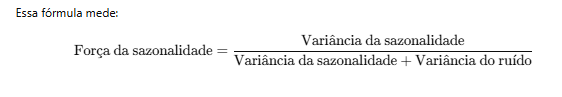

| Valor         | Interpretação                     |
| ------------- | --------------------------------- |
| **< 0.2**     | Sazonalidade fraca ou inexistente |
| **0.2 – 0.4** | Sazonalidade moderada             |
| **0.4 – 0.6** | Sazonalidade forte                |
| **> 0.6**     | Sazonalidade muito forte          |


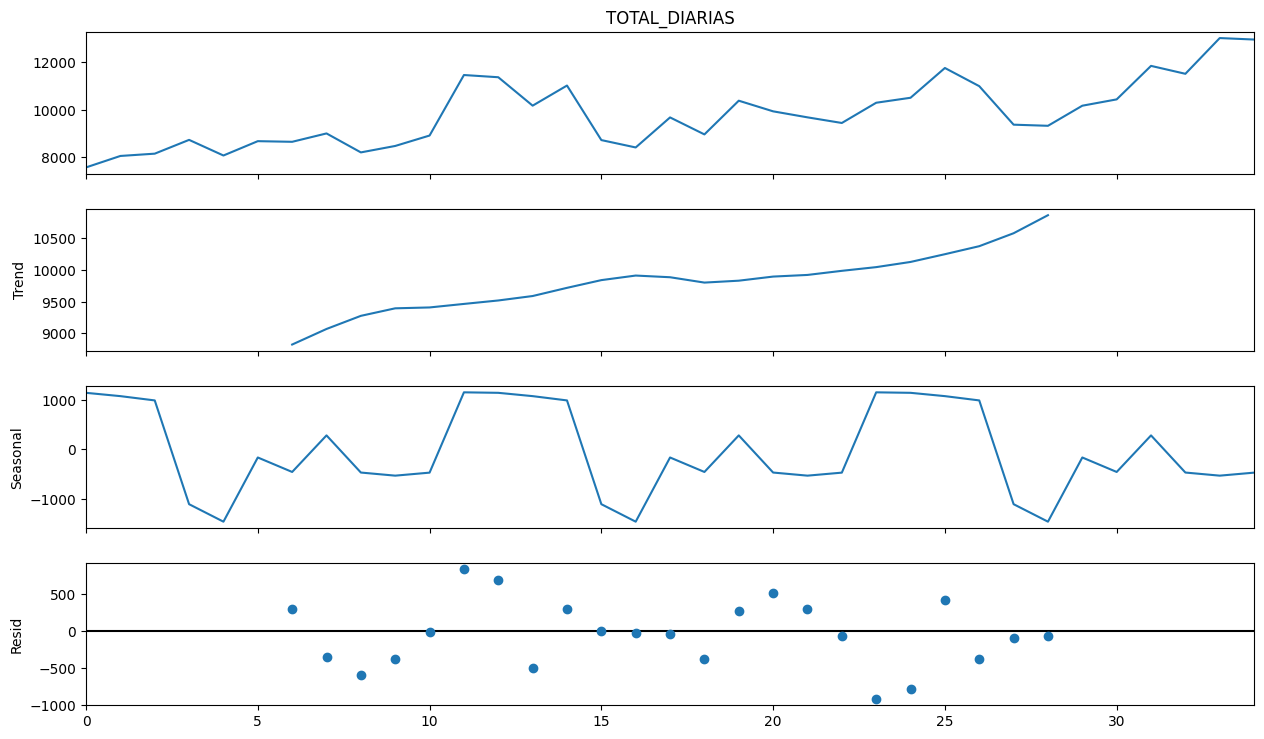

In [12]:
serie = tabela_mensal['TOTAL_DIARIAS']

# Decomposição aditiva
decomposicao = seasonal_decompose(
    serie,
    model='additive',
    period=12
)

fig = decomposicao.plot()
fig.set_size_inches(14, 8)
plt.show()


1- Tendência clara de crescimento ao longo do tempo

2️ - O gráfico de tendência mostra:

Crescimento relativamente suave

Pequena desaceleração no meio
Modelos adequados:

SARIMA com d=1 (Recomendado, não uma regra)

3- Sazonalidade
Padrão que se repete

Meses consistentemente positivos

Meses consistentemente negativos

Amplitude parecida ao longo do tempo

4 - Resíduo = o que sobrou depois de tirar tendência e sazonalidade

🎯 O que significam resíduos positivos e negativos?

Se:

Resíduo positivo → valor real foi maior que o esperado

Resíduo negativo → valor real foi menor que o esperado

Exemplo:

Se em um mês o modelo esperava 10.000
E você teve 10.800

Resíduo = +800

Isso pode indicar:

Evento promocional

Pico de demanda

Fator externo

<Figure size 1000x500 with 0 Axes>

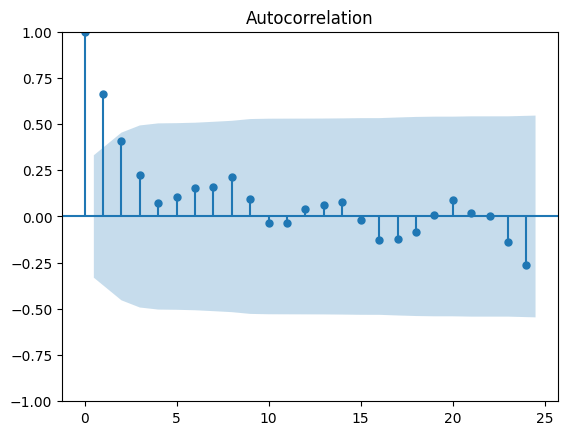

In [13]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10,5))
plot_acf(serie, lags=24)
plt.show()


Decaimento lento da ACF

Quando a ACF:

Começa alta

Vai diminuindo gradualmente

Não corta abruptamente

Isso indica não estacionariedade (tendência).

Ou seja:

Isso bate com o gráfico da série (crescimento claro).

<Figure size 1000x500 with 0 Axes>

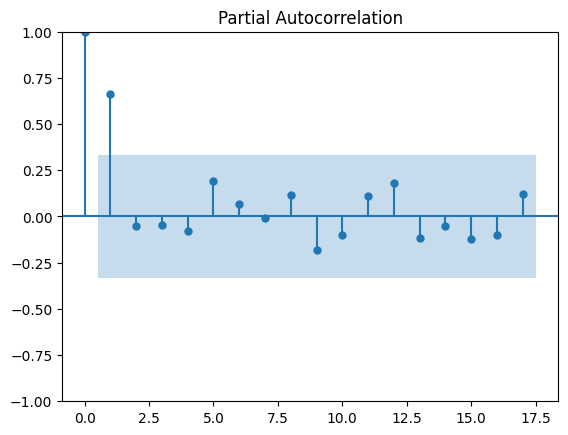

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(10,5))
plot_pacf(serie, lags=17, method='ywm')
plt.show()



🔎 O que o PACF mostra?

PACF mede:

Correlação direta entre Yₜ e Yₜ₋ₖ removendo efeitos intermediários.

Quando o PACF:
Tem pico forte no lag 1

E depois corta abruptamente
Isso indica modelo AR(1).
Cruzando com seu ACF

Seu ACF mostrou:

Decaimento gradual

Não corte abrupto

Esse padrão combinado significa:

Modelo AR(1) com série não estacionária
Ou seja:

ARIMA(1,1,0)

Por que ARIMA(1,1,0)?

d = 1 → porque ACF mostrou tendência

p = 1 → porque PACF cortou em 1

q = 0 → porque ACF não mostrou corte brusco típico de MA

# Sarima - MAE 833

In [15]:
tabela_mensal.head()

,ANO_MES,TOTAL_DIARIAS
0,2022-01-01,7579
1,2022-02-01,8059
2,2022-03-01,8155
3,2022-04-01,8733
4,2022-05-01,8078


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# Garantir ordenação e índice temporal
tabela_mensal = tabela_mensal.sort_values('ANO_MES')
tabela_mensal = tabela_mensal.set_index('ANO_MES')

serie = tabela_mensal['TOTAL_DIARIAS']


In [18]:
#MultiStep

horizonte = 9

treino = serie.iloc[:-horizonte]
teste = serie.iloc[-horizonte:]

modelo = SARIMAX(
    treino,
    order=(1,1,1),
    seasonal_order=(0,1,0,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

resultado = modelo.fit(disp=False)

forecast = resultado.get_forecast(steps=horizonte)
forecast_mean = forecast.predicted_mean

mae_multi = np.mean(np.abs(teste.values - forecast_mean.values))

print("MAE Multi-step 9M:", mae_multi)


MAE Multi-step 9M: 911.6191451158431


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [21]:
import numpy as np
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

horizonte = 9

treino = serie.iloc[:-horizonte]
teste = serie.iloc[-horizonte:]

p = [0, 1, 2]
d = [0, 1]
q = [0, 1]

P = [0, 1]
D = [0, 1]
Q = [0, 1]
s = 12

melhor_mae = np.inf
melhor_param = None

for order in itertools.product(p, d, q):
    for seasonal in itertools.product(P, D, Q):

        seasonal_order = (seasonal[0], seasonal[1], seasonal[2], s)

        try:
            modelo = SARIMAX(
                treino,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=True
            )

            resultado = modelo.fit(disp=False)

            forecast = resultado.get_forecast(steps=horizonte)
            forecast_mean = forecast.predicted_mean

            mae = np.mean(np.abs(teste.values - forecast_mean.values))

            if mae < melhor_mae:
                melhor_mae = mae
                melhor_param = (order, seasonal_order)

        except:
            continue

print("====================================")
print("Melhor configuração encontrada:")
print("Order:", melhor_param[0])
print("Seasonal Order:", melhor_param[1])
print("Melhor MAE:", round(melhor_mae,2))
print("====================================")


Melhor configuração encontrada:
Order: (1, 0, 1)
Seasonal Order: (1, 0, 1, 12)
Melhor MAE: 833.52


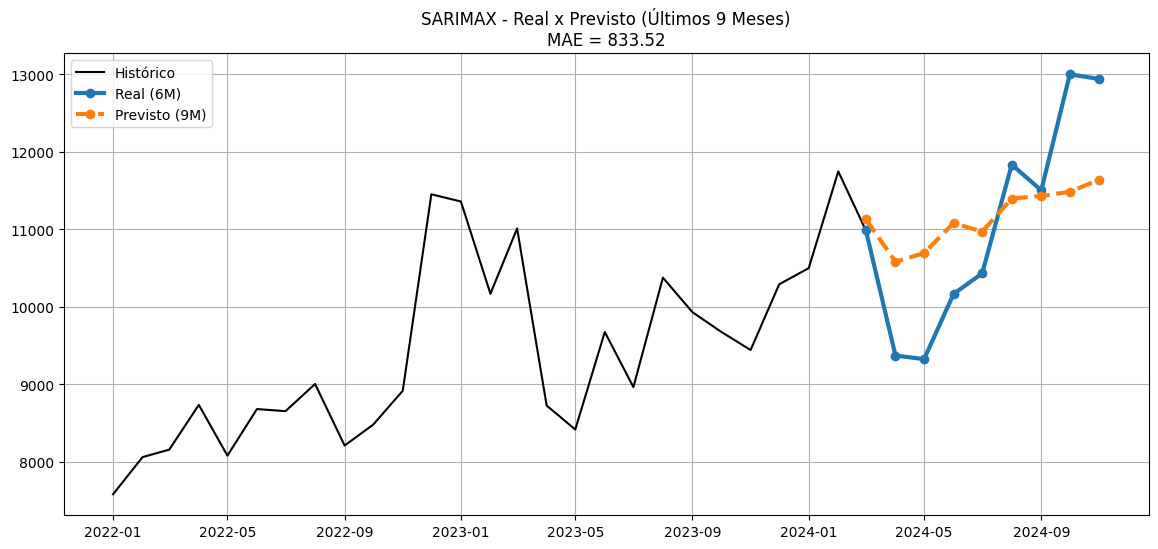

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ==========================
# Recriar treino e teste
# ==========================

horizonte = 9
treino = serie.iloc[:-horizonte]
teste = serie.iloc[-horizonte:]

# ==========================
# Usar melhores parâmetros encontrados
# ==========================

best_order = melhor_param[0]
best_seasonal = melhor_param[1]

modelo_final = SARIMAX(
    treino,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=True
)

resultado_final = modelo_final.fit(disp=False)

forecast = resultado_final.get_forecast(steps=horizonte)
forecast_mean = forecast.predicted_mean

mae = mean_absolute_error(teste, forecast_mean)

# ==========================
# Plot
# ==========================

plt.figure(figsize=(14,6))

# Histórico completo
plt.plot(serie.index, serie, label='Histórico', color='black')

# Real últimos 6 meses
plt.plot(teste.index, teste, marker='o', linewidth=3, label='Real (6M)')

# Previsto últimos 6 meses
plt.plot(teste.index, forecast_mean, marker='o', linestyle='--', linewidth=3,
         label='Previsto (9M)')

plt.title(f'SARIMAX - Real x Previsto (Últimos 9 Meses)\nMAE = {round(mae,2)}')
plt.legend()
plt.grid(True)

plt.show()


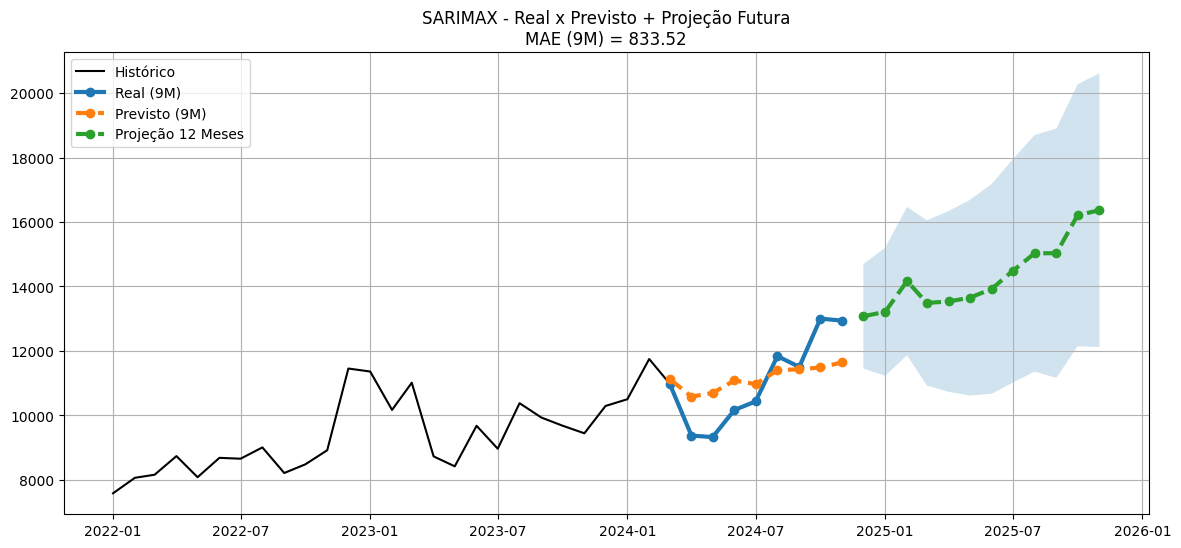

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ==========================
# Recriar treino e teste
# ==========================

horizonte = 9
treino = serie.iloc[:-horizonte]
teste = serie.iloc[-horizonte:]

# ==========================
# Usar melhores parâmetros encontrados
# ==========================

best_order = melhor_param[0]
best_seasonal = melhor_param[1]

modelo_final = SARIMAX(
    treino,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=True
)

resultado_final = modelo_final.fit(disp=False)

forecast = resultado_final.get_forecast(steps=horizonte)
forecast_mean = forecast.predicted_mean

mae = mean_absolute_error(teste, forecast_mean)

# ==========================
# 🔮 NOVO: Re-treinar com todos os dados
# ==========================

modelo_full = SARIMAX(
    serie,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=True
)

resultado_full = modelo_full.fit(disp=False)

forecast_future = resultado_full.get_forecast(steps=12)
forecast_12 = forecast_future.predicted_mean
conf_int = forecast_future.conf_int()

# ==========================
# Plot
# ==========================

plt.figure(figsize=(14,6))

# Histórico completo
plt.plot(serie.index, serie, label='Histórico', color='black')

# Real últimos 9 meses
plt.plot(teste.index, teste, marker='o', linewidth=3, label='Real (9M)')

# Previsto últimos 9 meses
plt.plot(teste.index, forecast_mean, marker='o', linestyle='--', linewidth=3,
         label='Previsto (9M)')

# 🔮 Projeção futura 12 meses
plt.plot(forecast_12.index, forecast_12,
         marker='o', linestyle='--', linewidth=3,
         label='Projeção 12 Meses')

# Intervalo de confiança
plt.fill_between(
    forecast_12.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    alpha=0.2
)

plt.title(f'SARIMAX - Real x Previsto + Projeção Futura\nMAE (9M) = {round(mae,2)}')
plt.legend()
plt.grid(True)

plt.show()


# Arima - MAE 943

In [24]:
tabela_mensal = tabela_mensal.reset_index()

if 'index' in tabela_mensal.columns:
    tabela_mensal = tabela_mensal.rename(columns={'index': 'ANO_MES'})


In [25]:
train = serie.iloc[:-9]
test  = serie.iloc[-9:]


In [26]:
from statsmodels.tsa.arima.model import ARIMA

modelo_arima = ARIMA(train, order=(1,1,0))
resultado = modelo_arima.fit()

print(resultado.summary())


                               SARIMAX Results                                
Dep. Variable:          TOTAL_DIARIAS   No. Observations:                   26
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -206.975
Date:                Sat, 21 Feb 2026   AIC                            417.950
Time:                        17:34:29   BIC                            420.388
Sample:                    01-01-2022   HQIC                           418.626
                         - 02-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0889      0.214     -0.415      0.678      -0.509       0.331
sigma2      9.035e+05   2.12e+05      4.259      0.000    4.88e+05    1.32e+06
Ljung-Box (L1) (Q):                   0.69   Jarque-

In [27]:
forecast = resultado.forecast(steps=9)

forecast.index = test.index  # alinhar datas


In [28]:
from sklearn.metrics import mean_absolute_error

mae_arima = mean_absolute_error(test, forecast)

print("MAE ARIMA(1,1,0):", mae_arima)


MAE ARIMA(1,1,0): 1213.5513786405158


In [29]:
import warnings
import itertools
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

warnings.filterwarnings("ignore")

# ==========================
# Espaço de busca ideal
# ==========================

p = range(0, 11)
q = range(0, 11)
d = [1]
trend_options = ['n', 'c']

parametros = list(itertools.product(p, d, q, trend_options))

print(f"Total de modelos a testar: {len(parametros)}")

resultados = []

# ==========================
# Grid Search
# ==========================

for param in parametros:

    p_val, d_val, q_val, trend = param

    try:
        modelo = ARIMA(
            train,
            order=(p_val, d_val, q_val),
            trend=trend,
            enforce_stationarity=False,
            enforce_invertibility=True
        )

        resultado = modelo.fit()

        forecast = resultado.forecast(steps=len(test))

        mae = mean_absolute_error(test, forecast)

        resultados.append({
            'p': p_val,
            'd': d_val,
            'q': q_val,
            'trend': trend,
            'MAE': mae,
            'AIC': resultado.aic,
            'BIC': resultado.bic
        })

    except:
        continue

# ==========================
# Resultado Final
# ==========================

df_resultados = pd.DataFrame(resultados)

df_resultados = df_resultados.sort_values('MAE').reset_index(drop=True)

print("\n🔝 Top 10 modelos:")
print(df_resultados.head(10))


Total de modelos a testar: 242

🔝 Top 10 modelos:
   p  d  q trend         MAE           AIC           BIC
0  4  1  6     n  943.066230  1.456581e+12  1.456581e+12
1  6  1  5     n  944.053264  8.876051e+04  8.877185e+04
2  6  1  1     n  971.767061  3.290535e+02  3.366091e+02
3  8  1  6     n  972.817419  5.067210e+16  5.067210e+16
4  7  1  0     n  975.443398  3.132698e+02  3.203927e+02
5  6  1  0     n  976.699206  3.270827e+02  3.336938e+02
6  8  1  4     n  978.239571  3.032113e+02  3.140431e+02
7  5  1  2     n  987.702332  3.443476e+02  3.523134e+02
8  9  1  0     n  988.019885  2.851963e+02  2.929222e+02
9  8  1  0     n  989.162874  2.988309e+02  3.063298e+02


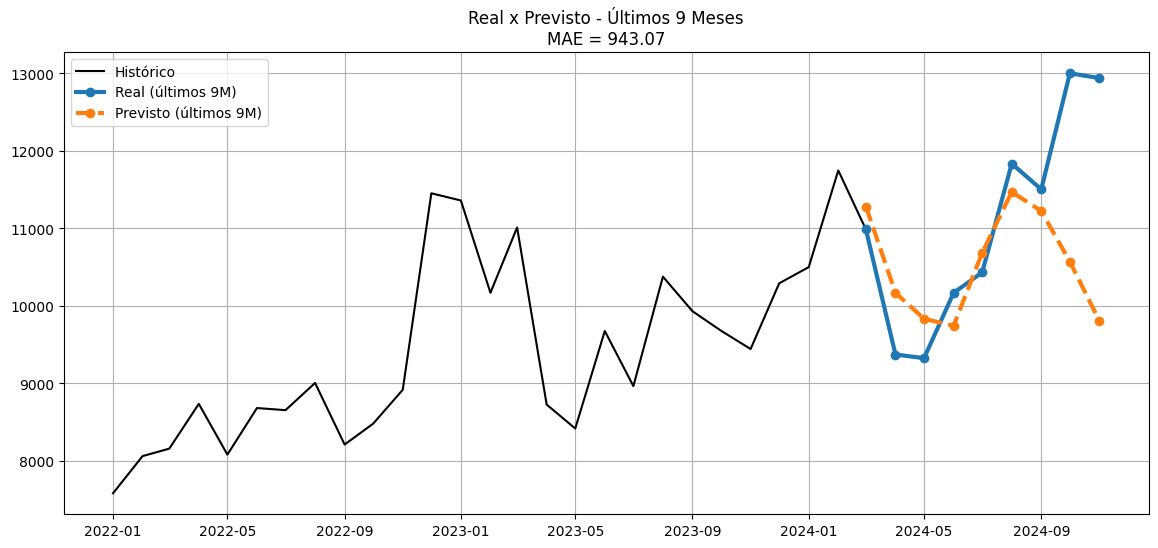

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

# ==========================
# Treinar melhor modelo
# (substitua pelos melhores parametros encontrados)
# ==========================

best_p = df_resultados.loc[0, 'p']
best_d = df_resultados.loc[0, 'd']
best_q = df_resultados.loc[0, 'q']
best_trend = df_resultados.loc[0, 'trend']

modelo = ARIMA(
    train,
    order=(best_p, best_d, best_q),
    trend=best_trend,
    enforce_stationarity=False,
    enforce_invertibility=True
)

resultado = modelo.fit()

# ==========================
# Previsão últimos 9 meses
# ==========================

forecast = resultado.forecast(steps=len(test))

mae = mean_absolute_error(test, forecast)

# ==========================
# Plot
# ==========================

plt.figure(figsize=(14,6))

# Histórico completo
plt.plot(serie.index, serie, label='Histórico', color='black')

# Real últimos 9 meses
plt.plot(test.index, test, marker='o', label='Real (últimos 9M)', linewidth=3)

# Previsto últimos 9 meses
plt.plot(test.index, forecast, marker='o', linestyle='--', label='Previsto (últimos 9M)', linewidth=3)

plt.title(f'Real x Previsto - Últimos 9 Meses\nMAE = {round(mae,2)}')
plt.legend()
plt.grid(True)

plt.show()


# Prophet - MAE 909

In [ ]:
!pip install prophet -q


In [32]:
df.head()

,CONTRATO,DATA_DA_CRIACAO,DIARIAS,VALOR_TOTAL,ORIGEM,ANO_MES
0,Loja 11000,2022-12-19,7,1933.88,SITE,2022-12
1,Loja 21001,2022-07-28,4,748.15,APLICATIVO,2022-07
2,Loja 11002,2023-08-20,6,459.04,PARCEIRO 1,2023-08
3,Loja 11003,2022-03-24,10,1079.76,PARCEIRO 2,2022-03
4,Loja 31004,2022-05-13,1,202.03,SITE,2022-05


In [33]:
df['ANO_MES'] = df['ANO_MES'].dt.to_timestamp()


In [34]:
import pandas as pd

# Garantir datetime
df['ANO_MES'] = pd.to_datetime(df['ANO_MES'])

# Agregar por mês
df_prophet = (
    df
    .groupby('ANO_MES')['DIARIAS']
    .sum()
    .reset_index()
)

# Renomear colunas para padrão Prophet
df_prophet = df_prophet.rename(columns={
    'ANO_MES': 'ds',
    'DIARIAS': 'y'
})

df_prophet = df_prophet.sort_values('ds')

df_prophet.head()


,ds,y
0,2022-01-01,7579
1,2022-02-01,8059
2,2022-03-01,8155
3,2022-04-01,8733
4,2022-05-01,8078


In [35]:
df_prophet = df_prophet.rename(columns={
    'ANO_MES': 'ds',
    'DIARIAS': 'y'
})

df_prophet = df_prophet.sort_values('ds')


In [36]:
train = df_prophet.iloc[:-9]
test  = df_prophet.iloc[-9:]


INFO:prophet:n_changepoints greater than number of observations. Using 19.


MAE Prophet (últimos 9 meses): 2470.84


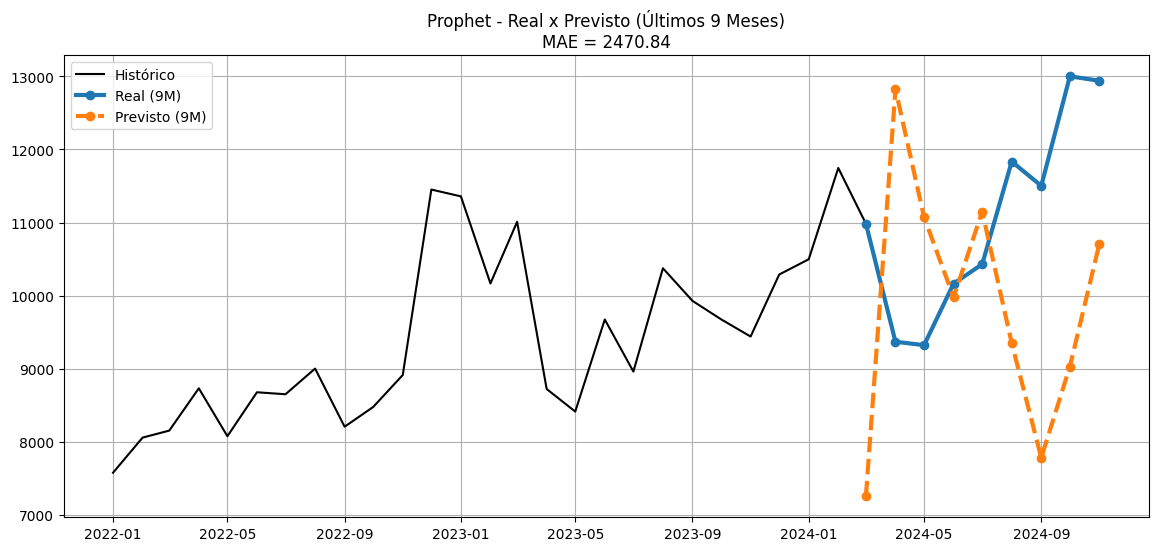

In [37]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# ==========================
# Treinar modelo simples
# ==========================

modelo = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

modelo.fit(train)

# ==========================
# Criar dataframe futuro
# ==========================

future = modelo.make_future_dataframe(periods=9, freq='MS')

forecast = modelo.predict(future)

# ==========================
# Pegar apenas os últimos 9 meses previstos
# ==========================

forecast_9 = forecast[['ds', 'yhat']].iloc[-9:]

# ==========================
# Calcular MAE
# ==========================

mae = mean_absolute_error(test['y'], forecast_9['yhat'])

print(f"MAE Prophet (últimos 9 meses): {round(mae,2)}")

# ==========================
# Plot
# ==========================

plt.figure(figsize=(14,6))

plt.plot(df_prophet['ds'], df_prophet['y'], label='Histórico', color='black')
plt.plot(test['ds'], test['y'], marker='o', linewidth=3, label='Real (9M)')
plt.plot(forecast_9['ds'], forecast_9['yhat'],
         marker='o', linestyle='--', linewidth=3,
         label='Previsto (9M)')

plt.title(f'Prophet - Real x Previsto (Últimos 9 Meses)\nMAE = {round(mae,2)}')
plt.legend()
plt.grid(True)

plt.show()


In [40]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import itertools
import pandas as pd
import numpy as np
import warnings
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)



warnings.filterwarnings("ignore")

horizonte = 9
train = df_prophet.iloc[:-horizonte]
test  = df_prophet.iloc[-horizonte:]

# ==========================
# Grade de parâmetros
# ==========================

changepoint_prior_scale = [0.001, 0.01, 0.05, 0.1, 0.2]
seasonality_prior_scale = [0.01, 0.1, 1, 5, 10]
n_changepoints = [5, 10, 15, 20]
seasonality_mode = ['additive', 'multiplicative']
changepoint_range = [0.8, 0.9]

param_grid = list(itertools.product(
    changepoint_prior_scale,
    seasonality_prior_scale,
    n_changepoints,
    seasonality_mode,
    changepoint_range
))

print(f'Total de combinações: {len(param_grid)}')

resultados = []

# ==========================
# Grid Search (SEM PRINT)
# ==========================

for params in param_grid:

    cps, sps, ncp, smode, cpr = params

    try:
        modelo = Prophet(
            growth='linear',
            changepoint_prior_scale=cps,
            seasonality_prior_scale=sps,
            n_changepoints=ncp,
            seasonality_mode=smode,
            changepoint_range=cpr,
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False
        )

        modelo.fit(train)

        future = modelo.make_future_dataframe(periods=horizonte, freq='MS')
        forecast = modelo.predict(future)

        forecast_9 = forecast[['ds', 'yhat']].iloc[-horizonte:]

        mae = mean_absolute_error(test['y'], forecast_9['yhat'])

        resultados.append({
            'cps': cps,
            'sps': sps,
            'n_changepoints': ncp,
            'seasonality_mode': smode,
            'changepoint_range': cpr,
            'MAE': mae
        })

    except:
        continue

# ==========================
# Resultado final
# ==========================

df_grid_prophet = pd.DataFrame(resultados)
df_grid_prophet = df_grid_prophet.sort_values('MAE').reset_index(drop=True)

print("\n====================================")
print("Melhor modelo encontrado:")
print(df_grid_prophet.iloc[0])
print("====================================")


Total de combinações: 400

Melhor modelo encontrado:
cps                       0.001
sps                        0.01
n_changepoints               20
seasonality_mode       additive
changepoint_range           0.8
MAE                  909.301851
Name: 0, dtype: object


MAE FINAL Prophet (9 meses): 909.3


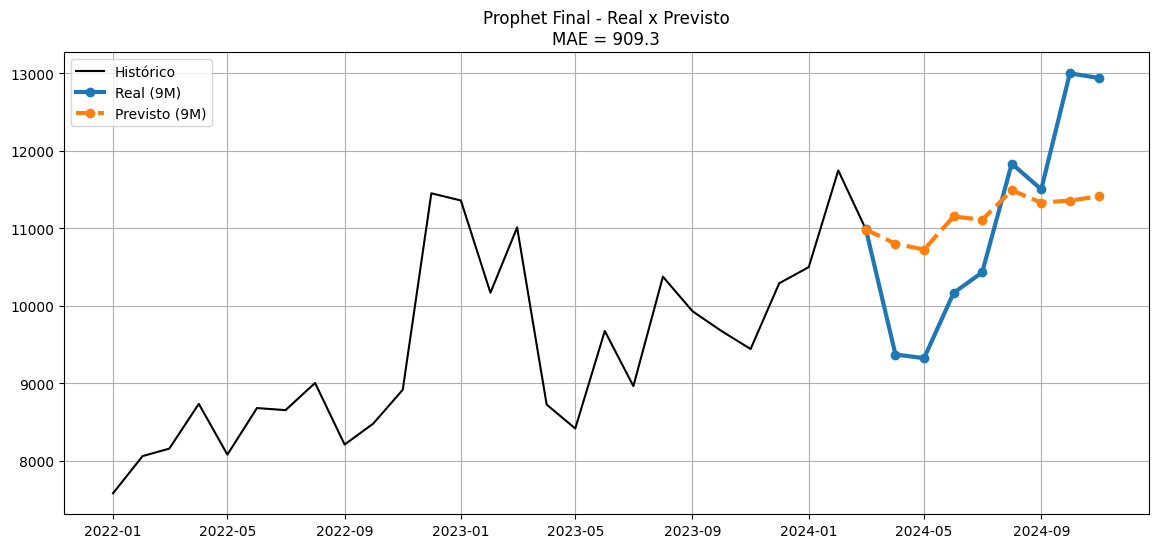

In [41]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

horizonte = 9

train = df_prophet.iloc[:-horizonte]
test  = df_prophet.iloc[-horizonte:]

# ==========================
# Melhor modelo encontrado
# ==========================

modelo_final = Prophet(
    growth='linear',
    changepoint_prior_scale=0.001,
    seasonality_prior_scale=0.01,
    n_changepoints=20,
    seasonality_mode='additive',
    changepoint_range=0.8,
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

modelo_final.fit(train)

# ==========================
# Previsão
# ==========================

future = modelo_final.make_future_dataframe(periods=horizonte, freq='MS')
forecast = modelo_final.predict(future)

forecast_9 = forecast[['ds', 'yhat']].iloc[-horizonte:]

mae = mean_absolute_error(test['y'], forecast_9['yhat'])

print(f"MAE FINAL Prophet (9 meses): {round(mae,2)}")

# ==========================
# Plot
# ==========================

plt.figure(figsize=(14,6))

plt.plot(df_prophet['ds'], df_prophet['y'], label='Histórico', color='black')
plt.plot(test['ds'], test['y'], marker='o', linewidth=3, label='Real (9M)')
plt.plot(forecast_9['ds'], forecast_9['yhat'],
         marker='o', linestyle='--', linewidth=3,
         label='Previsto (9M)')

plt.title(f'Prophet Final - Real x Previsto\nMAE = {round(mae,2)}')
plt.legend()
plt.grid(True)

plt.show()


# Benchmark de modelos univariados via StatsForecast - Melhor MAE: Theta  1109

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, Theta, SeasonalNaive, Naive
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np

# ==========================
# Preparar dados
# ==========================

horizonte = 9

df_sf = df_prophet.copy()
df_sf['unique_id'] = 'serie'
df_sf = df_sf[['unique_id', 'ds', 'y']]

train = df_sf.iloc[:-horizonte]
test  = df_sf.iloc[-horizonte:]

# ==========================
# Definir modelos (Grid)
# ==========================

models = [
    AutoARIMA(season_length=12),
    AutoETS(season_length=12),
    Theta(season_length=12),
    SeasonalNaive(season_length=12),
    Naive()
]

# ==========================
# Rodar modelos
# ==========================

sf = StatsForecast(
    models=models,
    freq='MS',
    n_jobs=-1
)

forecast = sf.forecast(df=train, h=horizonte)

# ==========================
# Calcular MAE por modelo
# ==========================

resultados = []

for col in forecast.columns:
    if col != 'ds' and col != 'unique_id':

        mae = mean_absolute_error(test['y'].values, forecast[col].values)

        resultados.append({
            'Modelo': col,
            'MAE': mae
        })

df_resultados_sf = pd.DataFrame(resultados).sort_values('MAE').reset_index(drop=True)

print("\n🔝 Ranking dos modelos (StatsForecast):")
print(df_resultados_sf)



🔝 Ranking dos modelos (StatsForecast):
          Modelo          MAE
0          Theta  1109.805664
1        AutoETS  1156.806763
2      AutoARIMA  1248.444458
3          Naive  1248.444458
4  SeasonalNaive  1487.888916


# Resolução Final - Sarima 🏆

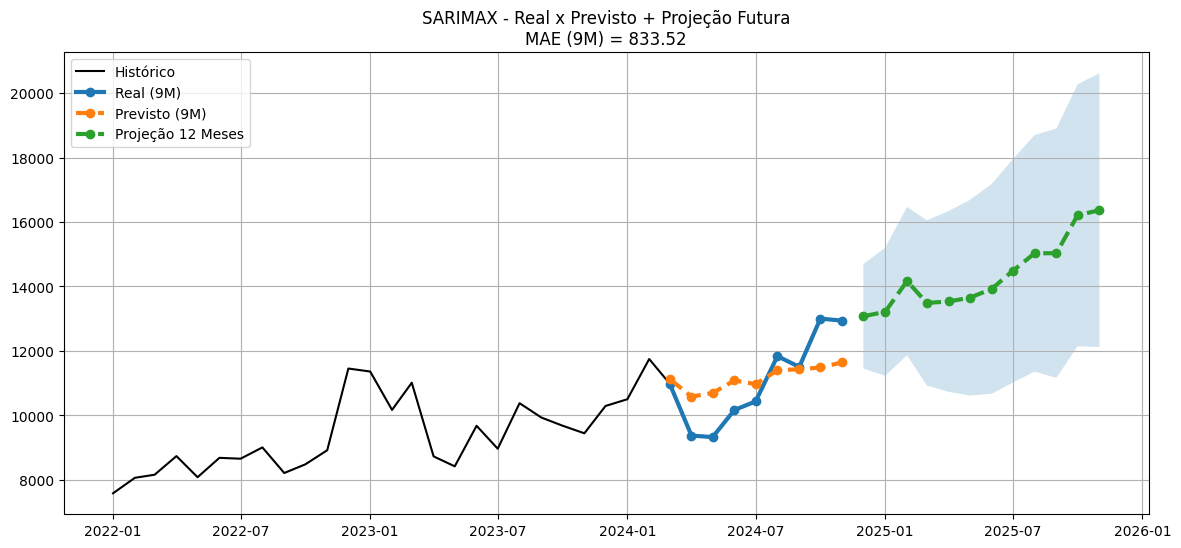

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings("ignore")

horizonte = 9
treino = serie.iloc[:-horizonte]
teste = serie.iloc[-horizonte:]


best_order = melhor_param[0]
best_seasonal = melhor_param[1]

modelo_final = SARIMAX(
    treino,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=True
)

resultado_final = modelo_final.fit(disp=False)

forecast = resultado_final.get_forecast(steps=horizonte)
forecast_mean = forecast.predicted_mean

mae = mean_absolute_error(teste, forecast_mean)


modelo_full = SARIMAX(
    serie,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=True
)

resultado_full = modelo_full.fit(disp=False)

forecast_future = resultado_full.get_forecast(steps=12)
forecast_12 = forecast_future.predicted_mean
conf_int = forecast_future.conf_int()


plt.figure(figsize=(14,6))

# Histórico completo
plt.plot(serie.index, serie, label='Histórico', color='black')

# Real últimos 9 meses
plt.plot(teste.index, teste, marker='o', linewidth=3, label='Real (9M)')

# Previsto últimos 9 meses
plt.plot(teste.index, forecast_mean, marker='o', linestyle='--', linewidth=3,
         label='Previsto (9M)')

# 🔮 Projeção futura 12 meses
plt.plot(forecast_12.index, forecast_12,
         marker='o', linestyle='--', linewidth=3,
         label='Projeção 12 Meses')

# Intervalo de confiança
plt.fill_between(
    forecast_12.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    alpha=0.2
)

plt.title(f'SARIMAX - Real x Previsto + Projeção Futura\nMAE (9M) = {round(mae,2)}')
plt.legend()
plt.grid(True)

plt.show()


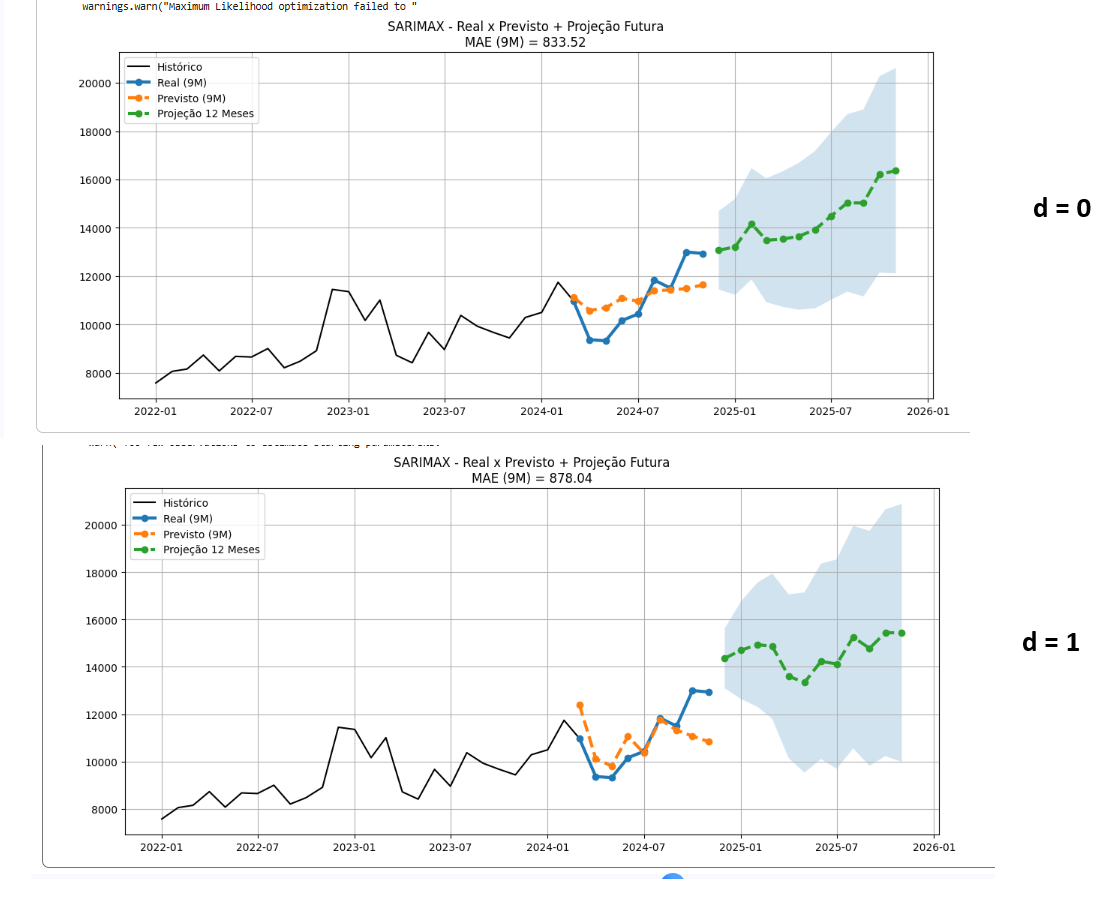

Apesar da presença de tendência visual, o modelo com d=0 apresentou melhor desempenho fora da amostra, indicando que a estrutura autoregressiva e sazonal foi suficiente para capturar a dinâmica da série sem necessidade de diferenciação adicional

📌 4️⃣ Por que d=1 piorou?

Quando você diferencia:

Remove tendência

Mas também remove parte da estrutura de longo prazo

Aumenta variância

Pode amplificar ruído

Com poucos dados (≈ 30 meses), isso pesa muito.

In [45]:
import numpy as np
import pandas as pd

# DataFrame simples
df_tendencia = pd.DataFrame({
    'Real': teste,
    'Previsto': forecast_mean
})

# Valor real anterior ao primeiro mês do teste
ultimo_real = treino.iloc[-1]

acertos = []

for i in range(len(df_tendencia)):

    if i == 0:
        base = ultimo_real
    else:
        base = df_tendencia['Real'].iloc[i-1]

    var_real = df_tendencia['Real'].iloc[i] - base
    var_prev = df_tendencia['Previsto'].iloc[i] - base

    acertou = np.sign(var_real) == np.sign(var_prev)
    acertos.append(acertou)

df_tendencia['Acertou_Tendencia'] = acertos

# Acurácia
acuracia = df_tendencia['Acertou_Tendencia'].mean()

print("Acurácia Direcional:", round(acuracia*100,2), "%")
df_tendencia


Acurácia Direcional: 77.78 %


,Real,Previsto,Acertou_Tendencia
2024-03-01,10984,11128.526612,True
2024-04-01,9370,10580.225992,True
2024-05-01,9323,10691.793895,False
2024-06-01,10165,11080.692247,True
2024-07-01,10430,10968.373978,True
2024-08-01,11834,11396.379713,True
2024-09-01,11502,11429.108476,True
2024-10-01,13000,11483.458209,False
2024-11-01,12938,11640.947895,True


MAE Rolling 1-Step (9 meses): 785.83


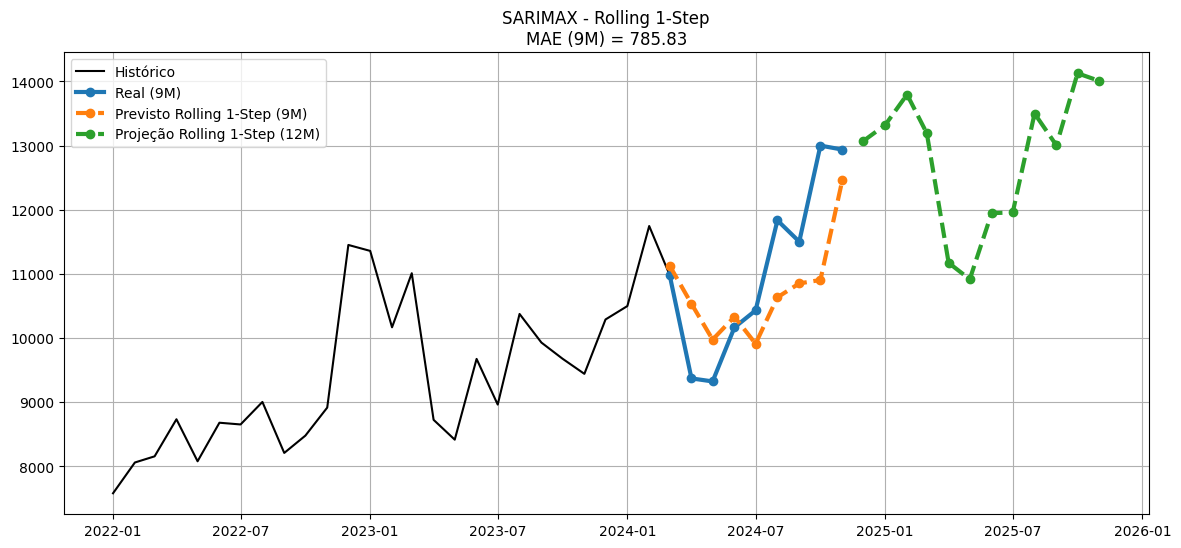

In [48]:
#Agora vamos usar o rolling 1step, normalmente o MAE fica melhor, pois ele vai ajustando o modelo de forma mensal até atingir o último mês, fica algo mais assertivo.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings("ignore")

# ==========================
# Configuração
# ==========================

horizonte_teste = 9
horizonte_futuro = 12

best_order = melhor_param[0]
best_seasonal = melhor_param[1]

serie_full = serie.copy()

# ==========================
# 🔵 1️⃣ Rolling 1-step para TESTE
# ==========================

previsoes_teste = []
valores_reais = []
datas_teste = []

for i in range(horizonte_teste):

    treino = serie_full.iloc[:-(horizonte_teste - i)]
    real = serie_full.iloc[-(horizonte_teste - i)]

    modelo = SARIMAX(
        treino,
        order=best_order,
        seasonal_order=best_seasonal,
        enforce_stationarity=False,
        enforce_invertibility=True
    )

    resultado = modelo.fit(disp=False)

    forecast = resultado.forecast(steps=1)

    previsoes_teste.append(forecast.iloc[0])
    valores_reais.append(real)
    datas_teste.append(serie_full.index[-(horizonte_teste - i)])

mae_rolling = mean_absolute_error(valores_reais, previsoes_teste)

print(f"MAE Rolling 1-Step (9 meses): {round(mae_rolling,2)}")

# ==========================
# 🔵 2️⃣ Rolling 1-step RECURSIVO para FUTURO
# ==========================

serie_temp = serie_full.copy()
previsoes_futuras = []
datas_futuras = []

for i in range(horizonte_futuro):

    modelo = SARIMAX(
        serie_temp,
        order=best_order,
        seasonal_order=best_seasonal,
        enforce_stationarity=False,
        enforce_invertibility=True
    )

    resultado = modelo.fit(disp=False)

    forecast = resultado.forecast(steps=1)
    previsao_mes = forecast.iloc[0]

    nova_data = serie_temp.index[-1] + pd.offsets.MonthBegin(1)

    previsoes_futuras.append(previsao_mes)
    datas_futuras.append(nova_data)

    # adiciona previsão ao histórico (recursivo)
    serie_temp.loc[nova_data] = previsao_mes

# ==========================
# Plot
# ==========================

plt.figure(figsize=(14,6))

# Histórico
plt.plot(serie_full.index, serie_full, label='Histórico', color='black')

# Rolling 1-step teste
plt.plot(datas_teste, valores_reais,
         marker='o', linewidth=3, label='Real (9M)')

plt.plot(datas_teste, previsoes_teste,
         marker='o', linestyle='--', linewidth=3,
         label='Previsto Rolling 1-Step (9M)')

# Rolling futuro
plt.plot(datas_futuras, previsoes_futuras,
         marker='o', linestyle='--', linewidth=3,
         label='Projeção Rolling 1-Step (12M)')

plt.title(f'SARIMAX - Rolling 1-Step\nMAE (9M) = {round(mae_rolling,2)}')
plt.legend()
plt.grid(True)

plt.show()


# Resumo final do projeto

Conseguimos um MAE de 833, equivalente a cerca de 6,4% de variancia comparado vs o pico mais recente de diarias dos dados, com cerca de 13 mil diárias ao mês.
Com uma acuracidade boa de 77% o modelo foi bem assertivo.

Realizando Rolling 1step o MAE melhorou e a previsão ficou também algo mais próximo do real, isso serve para validar nosso modelo. Caso seja necessário um modelo que precise atualizar de forma mensal para prever o mês seguinte, é uma estratégia boa a sua utilização.


Lembrando que isso é um material com dados ficticios, com uma base de 35 meses fazer uma previsão no cenário real para os próximos 12 meses é muito perigoso, pois é uma base pequena para uma projeção longa.